# Exploration for corpus stats and initial topic modeling experiments

In [1]:
from pathlib import Path

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
import seaborn as sns

import topic_modeling.tokenization as tokenization
from topic_modeling.analysis import *
from topic_modeling.mallet_parser import *

# Read corpus

In [2]:
CORPUS_DIR = Path('/home/virginia/workspace/topic-modeling-study/russian_novels')
DOCS_TSV = CORPUS_DIR / 'russian_novels.tsv'
STOP_LIST = CORPUS_DIR / 'russian_novels_stopped.txt'
ORIGINAL_WORD_COUNTS = CORPUS_DIR / 'russian_novels_counts.tsv'


In [3]:
print("Original word counts")
original_word_counts = pd.read_csv(ORIGINAL_WORD_COUNTS, sep='\t', encoding='utf-8', names=['word','term_freq', 'doc_freq']) 
display(original_word_counts.head())
keep_set_for_cleaning = set(original_word_counts['word'])
print("Original vocabulary size:", len(keep_set_for_cleaning))


Original word counts


,word,term_freq,doc_freq
0,и,247754,10296
1,не,122673,10285
2,на,91762,10259
3,что,88897,10173
4,в,145809,10011


Original vocabulary size: 319459


In [4]:
stops = get_token_list(STOP_LIST)
print("Number of words pruned from vocab:", len(stops))
print("Vocabulary size after pruning:", len(keep_set_for_cleaning) - len(stops))

Number of words pruned from vocab: 238919
Vocabulary size after pruning: 80540


In [5]:
# Count how many stop word tokens are actually removed
stop_word_series = pd.DataFrame({'word':list(stops)})
original_stop_counts = pd.merge(stop_word_series, original_word_counts, on='word')
original_stop_counts.sort_values(by=['term_freq'], inplace=True, ascending=False)

print("Total number of tokens dropped by pruning:", original_stop_counts['term_freq'].sum())

Total number of tokens dropped by pruning: 2759861


In [6]:
corpus = pd.read_csv(DOCS_TSV, sep='\t', encoding='utf-8', names=['doc_id', 'author', 'text'], index_col=0)
corpus['author'] = corpus['author'].astype('category')

In [7]:
print("Number of documents:", len(corpus.index))
print("Number of authors:", len(set(corpus['author'])))
corpus.head()

Number of documents: 10303
Number of authors: 23


,author,text
doc_id,,
Turgenev_Rudin_0,Turgenev,I Было тихое летнее утро. Солнце уже довольно ...
Turgenev_Rudin_1,Turgenev,"-- Ну, прощай, Матрена! -- проговорила Алексан..."
Turgenev_Rudin_2,Turgenev,Александра Павловна отправилась тихонько назад...
Turgenev_Rudin_3,Turgenev,"-- Вас Дарья Михайловна ко мне прислала, говор..."
Turgenev_Rudin_4,Turgenev,"-- Ступай, барин, право... Константин Диомидыч..."


In [8]:
# We have to downcase and clean up numbers and other non-word things that Mallet eliminates
corpus['clean_text'] = corpus['text'].apply(get_clean_text, args=(keep_set_for_cleaning,))
corpus.head(2)

,author,text,clean_text
doc_id,,,
Turgenev_Rudin_0,Turgenev,I Было тихое летнее утро. Солнце уже довольно ...,i было тихое летнее утро солнце уже довольно в...
Turgenev_Rudin_1,Turgenev,"-- Ну, прощай, Матрена! -- проговорила Алексан...",ну прощай матрена проговорила александра павло...


In [9]:
corpus['stopped_text'] = corpus['clean_text'].apply(get_stopped_text, args=(stops,))
corpus.head(2)

,author,text,clean_text,stopped_text
doc_id,,,,
Turgenev_Rudin_0,Turgenev,I Было тихое летнее утро. Солнце уже довольно ...,i было тихое летнее утро солнце уже довольно в...,i тихое летнее утро солнце довольно высоко сто...
Turgenev_Rudin_1,Turgenev,"-- Ну, прощай, Матрена! -- проговорила Алексан...",ну прощай матрена проговорила александра павло...,прощай матрена проговорила александра павловна...


In [10]:
corpus['doc_length'] = corpus['clean_text'].apply(get_num_tokens)
corpus['stopped_length'] = corpus['stopped_text'].apply(get_num_tokens)
corpus.head(2)

,author,text,clean_text,stopped_text,doc_length,stopped_length
doc_id,,,,,,
Turgenev_Rudin_0,Turgenev,I Было тихое летнее утро. Солнце уже довольно ...,i было тихое летнее утро солнце уже довольно в...,i тихое летнее утро солнце довольно высоко сто...,484,279
Turgenev_Rudin_1,Turgenev,"-- Ну, прощай, Матрена! -- проговорила Алексан...",ну прощай матрена проговорила александра павло...,прощай матрена проговорила александра павловна...,477,250


# Corpus statistics
## Original (unpruned) corpus
Corpus is https://github.com/ginic/RussianNovels/tree/cleanups


In [11]:
print("Total documents:", len(corpus))
print("Document length statistics:")
print("Total tokens:", corpus['doc_length'].sum())
print("Original vocabulary size:", len(keep_set_for_cleaning))
corpus['doc_length'].describe()

Total documents: 10303
Document length statistics:
Total tokens: 6079657
Original vocabulary size: 319459


count    10303.000000
mean       590.086091
std        313.744992
min          0.000000
25%        481.000000
50%        497.000000
75%        553.000000
max       6724.000000
Name: doc_length, dtype: float64

In [12]:
by_author_stats = get_by_author_statistics(corpus, 'author', 'doc_length')
by_author_stats.head()

,author,doc_count,token_count,normalized_doc_length
0,Bulgakov,585,287112,490.789744
1,Chekhov,123,65340,531.219512
2,Dostoyevsky,1271,907889,714.310779
3,Durova,290,231560,798.482759
4,Gan,52,36793,707.557692


In [13]:
docs_by_author = by_author_stats.sort_values('doc_count', ascending=False)
print("How many documents do we have for each author?")
docs_by_author['doc_count'].describe()

How many documents do we have for each author?


count      23.000000
mean      447.956522
std       478.334846
min        15.000000
25%       128.000000
50%       224.000000
75%       591.500000
max      1570.000000
Name: doc_count, dtype: float64

In [14]:
print("Most prolific by docs")
display(docs_by_author.head())
print("Least prolific by docs")
display(docs_by_author.tail())

Most prolific by docs


,author,doc_count,token_count,normalized_doc_length
7,Gorky,1570,775552,493.982166
14,Sholokhov,1301,627393,482.239047
2,Dostoyevsky,1271,907889,714.310779
10,Nabokov,1121,899899,802.764496
16,Tolstoi,1064,608655,572.044173


Least prolific by docs


,author,doc_count,token_count,normalized_doc_length
13,SKhvoshchinskaya,77,43415,563.831169
21,Zhukova,56,35296,630.285714
4,Gan,52,36793,707.557692
19,Volkonskaya,25,13148,525.920000
22,Zinovieva-Annibal,15,7197,479.800000


<AxesSubplot:xlabel='doc_count', ylabel='author'>

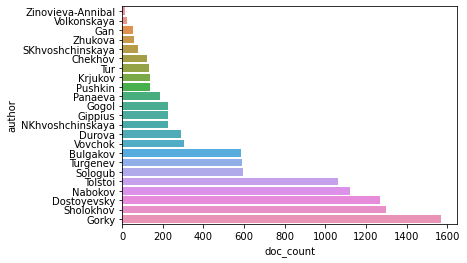

In [15]:
sns.barplot(data=by_author_stats, y='author', x='doc_count', order=by_author_stats.sort_values('doc_count').author)

In [16]:
print("How many tokens do we have for each author?")
tokens_by_author = by_author_stats.sort_values('token_count', ascending=False)
tokens_by_author['token_count'].describe()

How many tokens do we have for each author?


count        23.000000
mean     264332.913043
std      290019.002273
min        7197.000000
25%       69767.500000
50%      121884.000000
75%      316153.500000
max      907889.000000
Name: token_count, dtype: float64

In [17]:
print("Most prolific by tokens")
display(tokens_by_author.head())
print("Least prolific by tokens")
display(tokens_by_author.tail())

Most prolific by tokens


,author,doc_count,token_count,normalized_doc_length
2,Dostoyevsky,1271,907889,714.310779
10,Nabokov,1121,899899,802.764496
7,Gorky,1570,775552,493.982166
14,Sholokhov,1301,627393,482.239047
16,Tolstoi,1064,608655,572.044173


Least prolific by tokens


,author,doc_count,token_count,normalized_doc_length
13,SKhvoshchinskaya,77,43415,563.831169
4,Gan,52,36793,707.557692
21,Zhukova,56,35296,630.285714
19,Volkonskaya,25,13148,525.920000
22,Zinovieva-Annibal,15,7197,479.800000


<AxesSubplot:xlabel='token_count', ylabel='author'>

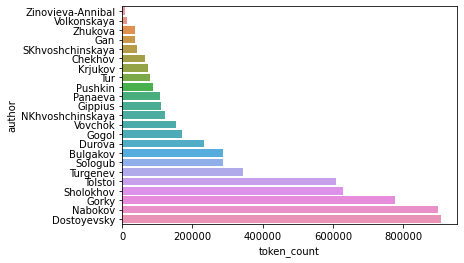

In [18]:
sns.barplot(data=tokens_by_author, y='author', x='token_count', order=tokens_by_author.sort_values('token_count').author)

In [19]:
print("Are there some authors that tend to have longer, 'denser' paragraphs/documents?")
by_author_stats['normalized_doc_length'].describe()


Are there some authors that tend to have longer, 'denser' paragraphs/documents?


count     23.000000
mean     588.627336
std      102.811675
min      479.800000
25%      502.284324
50%      563.831169
75%      634.617495
max      802.764496
Name: normalized_doc_length, dtype: float64

<AxesSubplot:xlabel='normalized_doc_length', ylabel='author'>

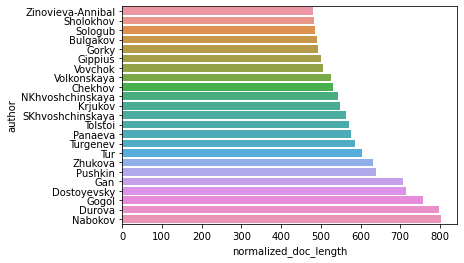

In [20]:
sns.barplot(data=tokens_by_author, y='author', x='normalized_doc_length', order=tokens_by_author.sort_values('normalized_doc_length').author)

In [21]:
# TODO Are there words that are unique to a particular author? 
# TODO Are there authors that use certain words at significantly higher rates than others?
clean_word_counts = get_by_author_word_counts(corpus, 'clean_text', 'author')
clean_word_counts.head()

,Chekhov,Gogol,Pushkin,Volkonskaya,Tur,Turgenev,Panaeva,Sholokhov,NKhvoshchinskaya,Gan,...,Nabokov,Gippius,Dostoyevsky,Zinovieva-Annibal,Bulgakov,SKhvoshchinskaya,Gorky,Sologub,Durova,Krjukov
a,3.0,1.0,3.0,0.0,0.0,52.0,1.0,0.0,3.0,2.0,...,115.0,2.0,25.0,0.0,1.0,0.0,3.0,1.0,4.0,0.0
a-houri-sang,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
abbasi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Visualization piece: 1d strip plot seaborn
# token count / total author words 
# y is randomly placed vertically so you can see them

# Comparing pre-lemmatization and post-lemmatization for terms 
# Later: Gamma dist with variance and mean

## Pruned corpus
Mallet corpus was pruned using the following settings:
- `MIN_TERM_FREQ := 5`: A term is pruned if it appears in less than 5 documents
 - `MIN_IDF := 1.39`: For Mallet, a given term's idf = ln(|corpus|/doc_freq), so 1.39 is 25% of corpus. Terms are pruned if they are in more than 25% of documents

Prune by running: `mallet prune --input input.mallet --output output_pruned.mallet --min-idf $(MIN_IDF) --prune-count $(MIN_TERM_FREQ)`


In [23]:
PRUNED_COUNTS = CORPUS_DIR / 'russian_novels_pruned_counts.tsv'
pruned_counts = pd.read_csv(PRUNED_COUNTS, sep='\t', encoding='utf-8', names=['word','term_freq', 'doc_freq']) 
display(pruned_counts.head())
print("Total tokens in pruned corpus according to Mallet (should be close to 'Total tokens' in next cell):", pruned_counts['term_freq'].sum())

,word,term_freq,doc_freq
0,совсем,3618,2554
1,стал,3395,2549
2,этой,3205,2518
3,которые,3638,2509
4,много,3355,2492


Total tokens in pruned corpus according to Mallet (should be close to 'Total tokens' in next cell): 3321349


TODO: Tokenization differences likely account for the differences between what I got and Mallet, should probably pull the regex over from Mallet instead of just splitting on whitespace:
https://github.com/mimno/Mallet/blob/12487de1aa6433bdcf5af0ee0a17b368e64c7acf/src/cc/mallet/classify/tui/Csv2Vectors.java#L110

In [24]:
print("Document length statistics:")
print("Total tokens:", corpus['stopped_length'].sum())
display(corpus['stopped_length'].describe())
print("Total number of tokens dropped by pruning:", original_stop_counts['term_freq'].sum())
print("Vocabulary size after pruning:", len(pruned_counts['word']))

Document length statistics:
Total tokens: 3321040


count    10303.000000
mean       322.337183
std        166.624077
min          0.000000
25%        260.000000
50%        281.000000
75%        311.000000
max       3345.000000
Name: stopped_length, dtype: float64

Total number of tokens dropped by pruning: 2759861
Vocabulary size after pruning: 80540


In [25]:
pruned_counts_by_author = by_author_stats = get_by_author_statistics(corpus, 'author', 'stopped_length')
pruned_counts_by_author['token_count'].describe()

count        23.000000
mean     144393.043478
std      156980.774844
min        3636.000000
25%       38316.500000
50%       65272.000000
75%      174191.000000
max      488674.000000
Name: token_count, dtype: float64

In [26]:
print("Most prolific by tokens after pruning")
display(pruned_counts_by_author.head())
print("Least prolific by tokens after pruning")
display(pruned_counts_by_author.tail())

Most prolific by tokens after pruning


,author,doc_count,token_count,normalized_doc_length
0,Bulgakov,585,161760,276.512821
1,Chekhov,123,34912,283.837398
2,Dostoyevsky,1271,463119,364.373721
3,Durova,290,128108,441.751724
4,Gan,52,20685,397.788462


Least prolific by tokens after pruning


,author,doc_count,token_count,normalized_doc_length
18,Turgenev,589,185759,315.380306
19,Volkonskaya,25,7070,282.800000
20,Vovchok,305,83184,272.734426
21,Zhukova,56,19257,343.875000
22,Zinovieva-Annibal,15,3636,242.400000


<AxesSubplot:xlabel='token_count', ylabel='author'>

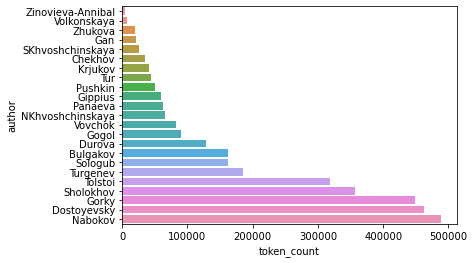

In [27]:
sns.barplot(data=pruned_counts_by_author, y='author', x='token_count', order=pruned_counts_by_author.sort_values('token_count').author)

In [28]:
print("Normalized token counts after pruning")
print("Are there some authors that tend to have longer, 'denser' paragraphs/documents?")
pruned_counts_by_author['normalized_doc_length'].describe()


Normalized token counts after pruning
Are there some authors that tend to have longer, 'denser' paragraphs/documents?


count     23.000000
mean     322.755607
std       55.742267
min      242.400000
25%      279.656410
50%      309.044444
75%      353.756341
max      441.751724
Name: normalized_doc_length, dtype: float64

<AxesSubplot:xlabel='normalized_doc_length', ylabel='author'>

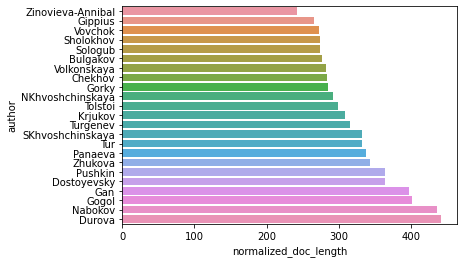

In [29]:
sns.barplot(data=pruned_counts_by_author, y='author', x='normalized_doc_length', order=pruned_counts_by_author.sort_values('normalized_doc_length').author)

In [30]:
stop_word_counts = get_by_author_word_counts(corpus, 'stopped_text', 'author')
stop_word_counts.head()

,Chekhov,Gogol,Pushkin,Volkonskaya,Tur,Turgenev,Panaeva,Sholokhov,NKhvoshchinskaya,Gan,...,Nabokov,Gippius,Dostoyevsky,Zinovieva-Annibal,Bulgakov,SKhvoshchinskaya,Gorky,Sologub,Durova,Krjukov
a,3.0,1.0,3.0,0.0,0.0,52.0,1.0,0.0,3.0,2.0,...,115.0,2.0,25.0,0.0,1.0,0.0,3.0,1.0,4.0,0.0
ada,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adieu,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ah,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,...,5.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ai,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Analysis of topics
A topic model was trained on the pruned corpus with the following settings:
- `NUM_TOPICS := 100`
- `NUM_ITERS := 1000`
- `OPTIMIZE_INTERVAL := 20`
- `OPTIMIZE_BURN_IN := 50`

Mallet training command:
`mallet train-topics $(MALLET_TOPIC_FLAGS) --input input_pruned.mallet --output-state $(state) --output-model $(output_model) --output-doc-topics $(doc_topics) --output-topic-keys $(topic_keys)`

In [31]:
EXPERIMENT_DIR = Path('/home/virginia/workspace/topic-modeling-study/russian_novels/russian_novels_100topics_1000iters')
# Mallet ouput with manually added comments on topic quality
TOPIC_KEYS = EXPERIMENT_DIR / 'russian_novels_100topics_1000iters_topic_keys_with_comments.tsv'

In [32]:
topics = pd.read_csv(TOPIC_KEYS, sep='\t', encoding='utf-8', index_col=0)
topics.head()

,topic_proportion_per_doc,tokens,comment
tid,,,
0,0.00610,литвинов ирина прокуратор пилат литвинова поту...,Bulgakov – Master and Margarita
1,0.02477,григорий аксинья пантелей прокофьевич петро на...,Tolstoy – War and Peace
2,0.05131,круг лишь времени пока которой однако столь ны...,connecting words and adverbs topic (but also ‘...
3,0.04771,чтоб ж б наконец графиня надобно граф однако с...,"particle and adverb topic, very common words (..."
4,0.00955,цинциннат м-сье пьер маменька дедушка ивановна...,"family members, names and titles"


## Author entropy
Produced with command:
`python ~/workspace/authorless-tms/topic_author_correlation.py --input russian_novels.tsv --vocab russian_novels_pruned_vocab.txt --input-state russian_novels_100topics_1000iters/russian_novels_100topics_1000iters.gz --output russian_novels_100topics_1000iters/russian_novels_100topics_1000iters_author_correlation.tsv`


In [33]:
AUTHOR_CORRELS = EXPERIMENT_DIR/'russian_novels_100topics_1000iters_author_correlation.tsv'
DIAGNOSTICS_XML = EXPERIMENT_DIR/'russian_novels_100topics_1000iters_diagnostics.xml'

In [34]:
author_correls = pd.read_csv(AUTHOR_CORRELS, sep='\t', encoding='utf-8', index_col=0)
author_correls.head()

,Author Entropy,Minus Major Author,Balanced Authors
Topic,,,
0,0.904924,0.244517,0.434387
1,0.265061,0.412718,0.404191
2,0.579936,0.233994,0.283639
3,1.300572,0.083752,0.098598
4,1.596524,0.145853,0.274923


<AxesSubplot:xlabel='Author Entropy', ylabel='Count'>

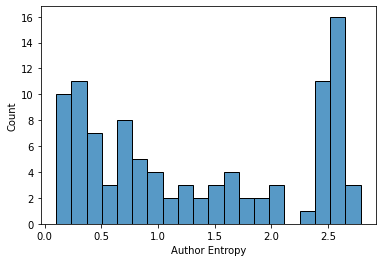

In [35]:
sns.histplot(data=author_correls['Author Entropy'], bins=20)

<AxesSubplot:xlabel='Minus Major Author', ylabel='Count'>

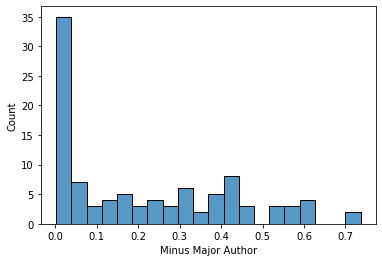

In [36]:
sns.histplot(data=author_correls['Minus Major Author'], bins=20)

<AxesSubplot:xlabel='Balanced Authors', ylabel='Count'>

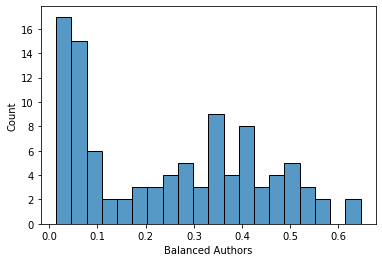

In [37]:
sns.histplot(data=author_correls['Balanced Authors'], bins=20)

In [38]:
# Look at overall metrics
topic_metrics = diagnostics_xml_to_dataframe(DIAGNOSTICS_XML).rename(columns={"tokens":"tokens_metric"})
topic_metrics.head()

,tokens_metric,document_entropy,word-length,coherence,uniform_dist,corpus_dist,eff_num_words,token-doc-diff,rank_1_docs,allocation_ratio,allocation_count,exclusivity
id,,,,,,,,,,,,
0,6428.0,4.8810,7.40,-811.1163,5.0119,4.6547,131.6829,0.0202,0.2338,0.0,0.0433,0.8332
1,22917.0,6.2308,6.70,-377.3472,4.3635,3.5045,214.3589,0.0139,0.1880,0.0,0.0311,0.5890
2,38409.0,6.6454,5.10,-381.4426,3.4794,2.9284,1011.6927,0.0133,0.1247,0.0,0.0072,0.2327
3,36060.0,6.3210,5.35,-298.9373,3.9727,2.4711,551.5225,0.0074,0.0839,0.0,0.0286,0.1646
4,8527.0,5.2763,7.65,-932.9323,4.8594,4.1231,177.3430,0.0178,0.1739,0.0,0.0190,0.6162


In [39]:
topic_metrics.describe()

,tokens_metric,document_entropy,word-length,coherence,uniform_dist,corpus_dist,eff_num_words,token-doc-diff,rank_1_docs,allocation_ratio,allocation_count,exclusivity
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,33213.490000,6.396822,5.799000,-449.756395,4.388788,3.368973,409.821722,0.014780,0.136833,0.005748,0.039745,0.465281
std,32787.621029,1.253066,0.974912,157.394177,0.489299,0.767080,293.895147,0.014856,0.150221,0.049349,0.099289,0.205310
min,3672.000000,3.858600,2.700000,-949.884700,3.395100,1.736800,74.253500,0.000100,0.002100,0.000000,0.000000,0.109200
25%,11912.750000,5.335000,5.200000,-487.378825,4.009625,2.670850,163.923975,0.001100,0.017675,0.000000,0.000475,0.322125
50%,19636.000000,6.247250,5.750000,-417.042250,4.358550,3.464250,343.902150,0.012350,0.083700,0.000000,0.007200,0.445900
75%,48490.000000,7.513650,6.500000,-348.721700,4.782350,3.942925,615.418675,0.023325,0.217450,0.000000,0.036175,0.617025
max,188712.000000,8.564000,8.250000,-110.403500,5.432500,4.912600,1154.326000,0.069900,0.794600,0.493000,0.842900,0.914500


<AxesSubplot:xlabel='coherence', ylabel='Count'>

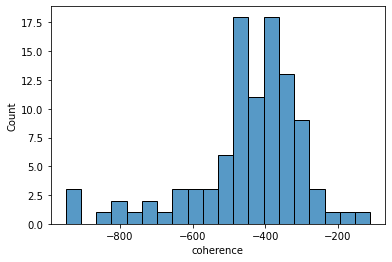

In [40]:
sns.histplot(data=topic_metrics['coherence'], bins=20)

<AxesSubplot:xlabel='document_entropy', ylabel='Count'>

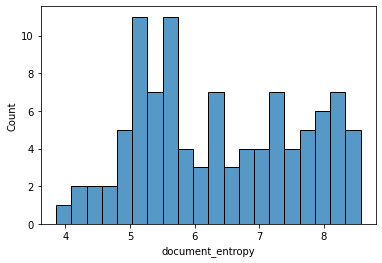

In [41]:
sns.histplot(data=topic_metrics['document_entropy'], bins=20)

<AxesSubplot:xlabel='uniform_dist', ylabel='Count'>

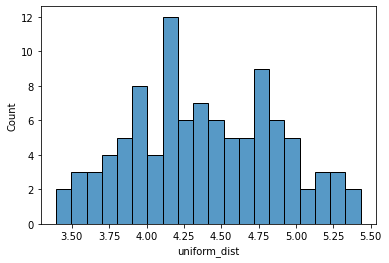

In [42]:
sns.histplot(data=topic_metrics['uniform_dist'], bins=20)

<AxesSubplot:xlabel='corpus_dist', ylabel='Count'>

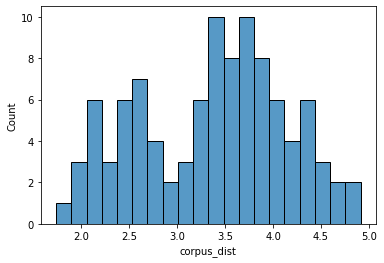

In [43]:
sns.histplot(data=topic_metrics['corpus_dist'], bins=20)

<AxesSubplot:xlabel='exclusivity', ylabel='Count'>

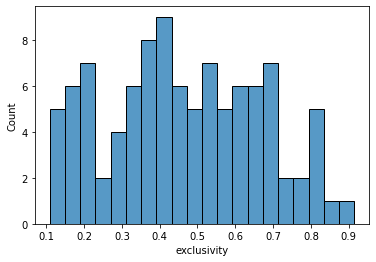

In [44]:
sns.histplot(data=topic_metrics['exclusivity'], bins=20)

In [45]:
# TODO Join in top documents per topic here
topics_with_entropy = pd.merge(topics, author_correls, left_index=True, right_index=True)
topics_with_entropy = pd.merge(topics_with_entropy, topic_metrics, left_index=True, right_index=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
# Sort by increasing entropy - lower entropy means a single author dominates that topic
# Higher Minus Major Author or Balanced Authors means that the distribution changes significantly,
# so a single author is using terms differently from others
topics_with_entropy.sort_values("Author Entropy").head(100)


,topic_proportion_per_doc,tokens,comment,Author Entropy,Minus Major Author,Balanced Authors,tokens_metric,document_entropy,word-length,coherence,uniform_dist,corpus_dist,eff_num_words,token-doc-diff,rank_1_docs,allocation_ratio,allocation_count,exclusivity
tid,,,,,,,,,,,,,,,,,,
23,0.00513,нежданов марианна соломин паклин сипягин маркелов нежданова калломейцев валентина михайловна машурина нежданову промолвил маркелова сипягина татьяна соломина отвечал остродумов алексей,names,0.101041,0.736654,0.645751,7734.0,4.8992,8.25,-341.9449,5.2436,4.2970,100.8106,0.0251,0.4792,0.0000,0.0260,0.7884
52,0.02472,клим лидия клима макаров лютов климу варавка самгин иноков спивак алина туробоев лидии дронов чтоб ответил пред макарова мать диомидов,Klim Sangin,0.147418,0.557213,0.519550,22391.0,6.3096,5.75,-348.3434,4.7825,3.4030,111.7620,0.0191,0.1401,0.0000,0.0069,0.6999
70,0.01266,ван ада вана люсетта марина демон ады the вану аде аду мадемуазель вин ларивьер адой ардис бланш демона лишь and,"Names, Nabokov - Ada",0.166383,0.616731,0.555628,14992.0,5.5914,4.65,-314.9739,4.3325,3.9397,142.0181,0.0267,0.2879,0.0000,0.0130,0.8115
60,0.01236,логин триродов елисавета клавдия логина петр анна остров андозерский мотовилов шестов триродова логину кирша молин тихо словно елена валя глава,"Names, Sologub – Bad Dreams",0.176239,0.596606,0.538629,14155.0,5.6855,6.20,-736.4128,4.6420,3.7821,197.5940,0.0323,0.3269,0.0000,0.0342,0.7100
61,0.00748,граф ея евстафий валериан астольда графа евстафия чтоб кауни лютгарда тодеуш астольды валериана этаго ксендз нибудь однакож клутницкий гедвига торгайло,"count (title), names",0.179681,0.567293,0.508892,16129.0,5.0346,6.60,-580.3590,4.3633,3.6240,383.0337,0.0179,0.4056,0.0000,0.2273,0.8332
92,0.00652,ортруда королева её танкред афра меччио всё королевы ортруды танкреда астольф лорена имогена ещё филиппо виктор принц принца ортруде ортруду,"queen, prince, names",0.183865,0.579977,0.494037,13618.0,5.0640,6.05,-234.7584,4.8883,4.0347,135.4167,0.0292,0.5341,0.0000,0.2972,0.8473
38,0.00695,франц кречмар магда драйер марта горн макс франца нужно быстро кречмара аннелиза драйера тихо автомобиль сейчас бруно глядя подумал господин,Names – Nabokov - Корол,0.184836,0.600660,0.562375,9205.0,5.0632,6.05,-474.6942,5.0184,4.1070,102.2685,0.0486,0.2546,0.0000,0.0037,0.6144
9,0.04684,самгин самгина клим самгину варвара чтоб марина подумал пред снова дронов иванович конечно тагильский вообще затем ответил чорт кутузов сердито,Gorky – the Life of Klim Samgin,0.201651,0.417979,0.429942,48357.0,6.8897,6.20,-347.5627,4.1509,2.7372,139.3415,0.0328,0.2741,0.0000,0.0209,0.3015
10,0.00819,передонов варвара саша людмила володин передонова вершина передонову марта рутилов ардальон думал сердито борисыч грушина словно сашу хрипач надежда владя,"Lots of names, mainly Sologob – Petty Demon",0.224079,0.543726,0.477409,13178.0,5.1992,6.75,-409.4211,4.8184,3.7387,113.9037,0.0402,0.4665,0.0052,0.2364,0.7318


## Morphological analysis of topics
Questions to answer:
- Which topics have multiple words with the same lemma? What about morphological variation on proper names?
- Which lemmas appear frequently across different topics? 
- Which topics contain many words of the same morphological type (e.g. past tense feminine sg verbs)? What types?
- Type-token ratio and character-token ratio broken down by author

In [54]:
'''python topic_modeling/mallet_parser.py slot-entropy russian_novels/russian_novels_100topics_1000iters/russian_novels_100topics_1000iters.gz russian_novels_entropy.tsv '''
SLOT_ENTROPY_METRICS = '/home/virginia/workspace/topic-modeling-study/russian_novels_entropy.tsv'
slot_entropy = pd.read_csv(SLOT_ENTROPY_METRICS, sep='\t', encoding='utf-8', index_col=0)
slot_entropy.head()



,slot_entropy,num_slots,pos_entropy,num_pos,lemma_entropy,num_lemmas
topic_id,,,,,,
0,6.444780,398,4.181880,58,8.459455,1458
1,6.622809,554,4.210103,78,9.086428,2961
2,6.904960,658,4.183042,84,10.477344,4317
3,7.126385,608,4.567786,86,9.671940,2942
4,6.516872,448,4.274645,68,8.624118,1801


In [62]:
topics_with_slot_entropy = pd.merge(topics, slot_entropy, left_index=True, right_index=True)
topics_with_slot_entropy = pd.merge(topics_with_slot_entropy, author_correls, left_index=True, right_index=True)
topics_with_slot_entropy = pd.merge(topics_with_slot_entropy, topic_metrics, left_index=True, right_index=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
topics_with_slot_entropy.sort_values("slot_entropy").head(100)



,topic_proportion_per_doc,tokens,comment,slot_entropy,num_slots,pos_entropy,num_pos,lemma_entropy,num_lemmas,Author Entropy,Minus Major Author,Balanced Authors,tokens_metric,document_entropy,word-length,coherence,uniform_dist,corpus_dist,eff_num_words,token-doc-diff,rank_1_docs,allocation_ratio,allocation_count,exclusivity
tid,,,,,,,,,,,,,,,,,,,,,,,,
24,0.02755,фр de la vous le et un je a mon c'est que pas il англ les mais est ma une,french,3.384741,426,2.255294,63,4.502320,1788,1.906310,0.049667,0.174358,12203.0,6.3050,2.70,-375.5495,4.8960,4.5655,175.4391,0.0204,0.0346,0.0021,0.0128,0.9145
28,0.01436,иванович иван петрович базаров аркадий николай павел ивана василий никифорович сергеевна петровича евгений ивановича афанасий промолвил одинцова базарова отвечал фенечка,men’s names,6.003523,428,4.058180,67,7.884433,1698,1.377359,0.181291,0.225558,9744.0,5.4883,7.50,-613.4885,5.4109,4.1025,74.2535,0.0193,0.1353,0.0000,0.0075,0.5796
85,0.33855,сама говорила спросила стала мать хотела думала нею начала продолжала могла пошла вышла сидела одна знала села ах долго встала,past tense fem verbs,6.209454,565,4.166009,74,9.669361,3520,2.745704,0.001711,0.014275,126197.0,8.4368,5.35,-401.4407,4.0203,2.0878,625.1413,0.0004,0.0286,0.0000,0.0015,0.3023
75,0.00960,лаврецкий павловна лиза рудин марья наталья михайловна дмитриевна дарья лежнев александра варвара пигасов паншин марфа волынцев рудина франц тимофеевна лемм,names,6.249460,421,4.221948,69,8.070744,1554,0.773754,0.330946,0.330110,9389.0,5.2482,6.85,-713.3572,5.1693,4.0999,137.3663,0.0103,0.2336,0.0000,0.0114,0.6486
23,0.00513,нежданов марианна соломин паклин сипягин маркелов нежданова калломейцев валентина михайловна машурина нежданову промолвил маркелова сипягина татьяна соломина отвечал остродумов алексей,names,6.259951,417,4.272519,66,8.228669,1579,0.101041,0.736654,0.645751,7734.0,4.8992,8.25,-341.9449,5.2436,4.2970,100.8106,0.0251,0.4792,0.0000,0.0260,0.7884
14,0.00857,елена андреевна шубин инсаров берсенев зоя мери андреевич прасковья васильевна соня сергей войницкий астров сергеевна любовь николай артемьевич вера елены,names,6.278272,426,4.247768,61,8.119352,1595,1.668029,0.123342,0.282611,8919.0,5.2260,6.75,-850.8365,5.2623,4.3316,100.4544,0.0151,0.2132,0.0000,0.0188,0.6975
45,0.00779,пнин яков лукич половцев пнина тимофей якова лукича джоан лятьевский гаген половцева платонович сергей якову бетти виктор миссис лукичу пнину,Nabokov – Pnin,6.302770,403,4.008640,59,8.258642,1678,1.045697,0.184108,0.377758,5599.0,5.0989,6.10,-924.1831,5.2331,4.9126,76.4167,0.0278,0.0799,0.0000,0.0000,0.7983
88,0.36048,ноги глазами рукой глаз головой глядя рядом губы груди руками медленно молча ногу смотрел пальцами рот голос зубы волосы лица,"body parts, especially the face",6.350910,615,3.742507,71,9.833849,4381,2.050368,0.005786,0.065458,124802.0,8.4835,5.30,-427.7662,3.6861,2.1870,863.8942,0.0001,0.0292,0.0000,0.0009,0.2382
78,0.01449,князь всё князя генерал аглая лизавета лебедев настасья филипповна рогожин ганя князю прокофьевна коля всё-таки то-есть евгений ипполит впрочем давеча,"prince, general, names",6.369905,476,4.452840,73,8.062903,2026,0.278302,0.375673,0.361184,19852.0,5.7209,6.55,-251.1321,5.1967,3.6915,78.5840,0.0187,0.2882,0.0000,0.0174,0.5702


<AxesSubplot:xlabel='slot_entropy', ylabel='Count'>

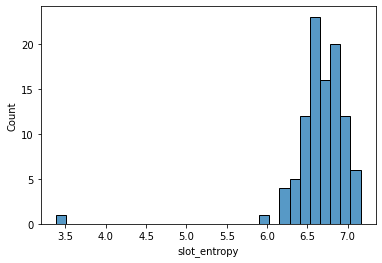

In [ ]:
sns.histplot(data=topics_with_slot_entropy['slot_entropy'], bins= 30)

<AxesSubplot:xlabel='lemma_entropy', ylabel='Count'>

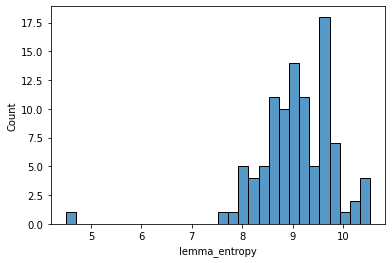

In [58]:
sns.histplot(data=topics_with_slot_entropy['lemma_entropy'], bins= 30)

<AxesSubplot:xlabel='pos_entropy', ylabel='Count'>

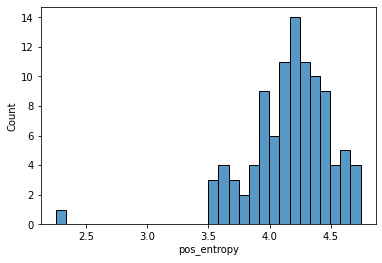

In [59]:
sns.histplot(data=topics_with_slot_entropy['pos_entropy'], bins= 30)